### Predicting Bank's Term Deposit Subscription

#### Author: Guansu(Frances) Niu

#### Data Resource: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [6]:
# Importing basic libraries:

import numpy as np
import pandas as pd
import seaborn as sns
import math as ma
import scipy.stats as st
import matplotlib
from matplotlib import pylab as plt
from sklearn.impute import SimpleImputer
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [7]:
# Reading the Dataset:

df = pd.read_csv('Original Data.csv',sep=';')

onehot_ftrs = ['job','marital','default','housing','loan','contact','poutcome']

ordinal_ftrs = ['education','month','day_of_week']

ordinal_cats = [['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 
                'university.degree','missing'],['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep','oct',
                'nov','dec'],['mon', 'tue', 'wed', 'thu', 'fri']]

num_ftrs = ['age','duration','campaign','previous','pdays','emp.var.rate','cons.price.idx','cons.conf.idx', 
                 'euribor3m','nr.employed']

In [8]:
# Onehot encoding('job','marital','default','housing','loan','contact','poutcome'):

ohe = OneHotEncoder(sparse=False)
si = SimpleImputer(missing_values='unknown',strategy='constant',fill_value='missing')
onehot_values = ohe.fit_transform(si.fit_transform(df[onehot_ftrs]))
onehot_ftr_names = ohe.get_feature_names()
df_onehot = pd.DataFrame(data=onehot_values,columns = onehot_ftr_names)

In [9]:
# Ordinal encoding('education','month','day_of_week'):

oe = OrdinalEncoder(categories = ordinal_cats)
si2 = SimpleImputer(missing_values='unknown',strategy='constant',fill_value='missing')
oe_values = oe.fit_transform(si2.fit_transform(df[ordinal_ftrs]))
df_ordinal = pd.DataFrame(data=oe_values,columns = ordinal_ftrs)

In [10]:
# StandardScaler('age','duration','campaign','previous','pdays','emp.var.rate','cons.price.idx',
# 'cons.conf.idx','euribor3m','nr.employed'):

# Missing values in 'pdays'
df[['pdays']] = df[['pdays']].replace(999, np.nan)

ss = StandardScaler()
num_values = ss.fit_transform(df[num_ftrs])
df_num = pd.DataFrame(data=num_values,columns = num_ftrs)

In [11]:
# Label encoding target variable('y'):

le = LabelEncoder()
df_le = pd.DataFrame(le.fit_transform(df['y']),columns=['y'])

In [12]:
# Creating new dataframe after preprocessing:

frames = [df_onehot,df_ordinal,df_num,df_le]
result = pd.concat(frames,sort=False, axis=1)

In [13]:
# MCAR test to check the reason of missing numberical values:

def checks_input_mcar_tests(data):
    """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
            """

    if not isinstance(data, pd.DataFrame):
        print("Error: Data should be a Pandas DataFrame")
        return False

    if not any(data.dtypes.values == np.float):
        if not any(data.dtypes.values == np.int):
            print("Error: Dataset cannot contain other value types than floats and/or integers")
            return False

    if not data.isnull().values.any():
        print("Error: No NaN's in given data")
        return False

    return True

def mcar_test(data):
    """ Implementation of Little's MCAR test
    Parameters
    ----------
    data: Pandas DataFrame
        An incomplete dataset with samples as index and variables as columns
    Returns
    -------
    p_value: Float
        This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
        'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
    """

    if not checks_input_mcar_tests(data):
        raise Exception("Input not correct")

    dataset = data.copy()
    vars = dataset.dtypes.index.values
    n_var = dataset.shape[1]

    # mean and covariance estimates
    # ideally, this is done with a maximum likelihood estimator
    gmean = dataset.mean()
    gcov = dataset.cov()

    # set up missing data patterns
    r = 1 * dataset.isnull()
    mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
    sorted_mdp = sorted(np.unique(mdp))
    n_pat = len(sorted_mdp)
    correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
    dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

    # calculate statistic and df
    pj = 0
    d2 = 0
    for i in range(n_pat):
        dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
        select_vars = ~dataset_temp.isnull().any()
        pj += np.sum(select_vars)
        select_vars = vars[select_vars]
        means = dataset_temp[select_vars].mean() - gmean[select_vars]
        select_cov = gcov.loc[select_vars, select_vars]
        mj = len(dataset_temp)
        parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
        d2 += mj * (np.dot(parta, means))

    df = pj - n_var

    # perform test and save output
    p_value = 1 - st.chi2.cdf(d2, df)

    return p_value

print(mcar_test(result))

# Since the p value > 0.05, the null hypothesis should be retained. 
# Due to > 79% of the rows have 'pdays' = 999, they should not be reduced.
# Therefore, the missingness mechanism of the incomplete dataset is MCAR, and column 'pdays'
# can be dropped. 

1.0


In [29]:
result.to_csv('Preprocessed Data.csv')

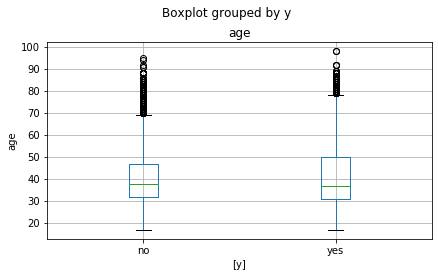

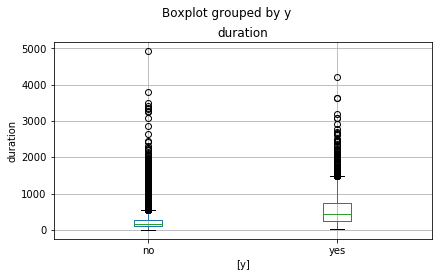

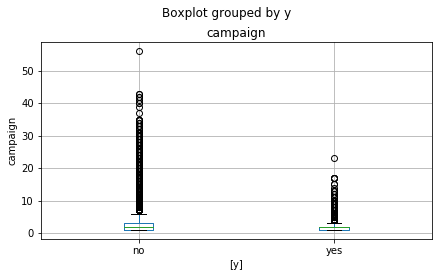

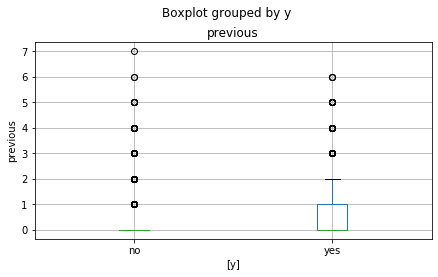

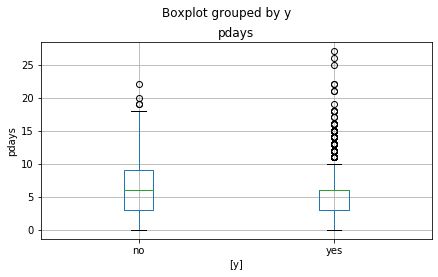

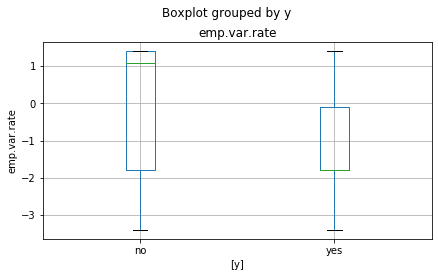

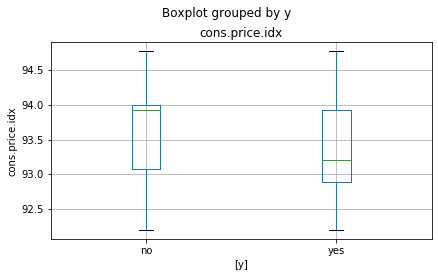

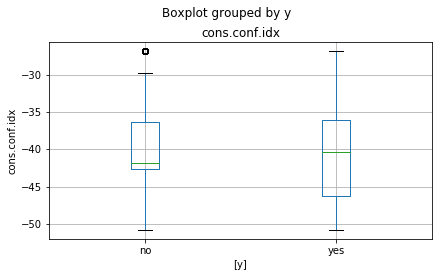

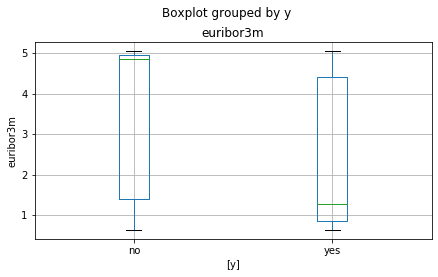

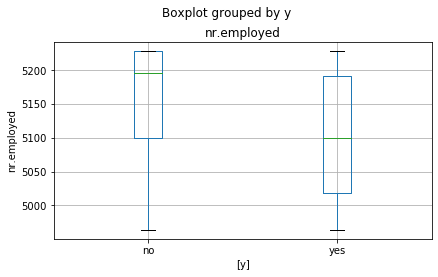

In [15]:
# EDA

# Continuous features and categorical label (Boxplot):

for i in range(len(num_ftrs)):
    df[[num_ftrs[i],'y']].boxplot(by='y')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.ylabel(num_ftrs[i])
plt.show()

In [16]:
# Average caculator:

df.groupby('y', as_index=False)['cons.conf.idx'].mean()

,y,cons.conf.idx
0,no,-40.593097
1,yes,-39.789784


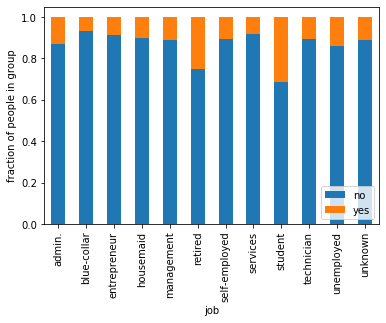

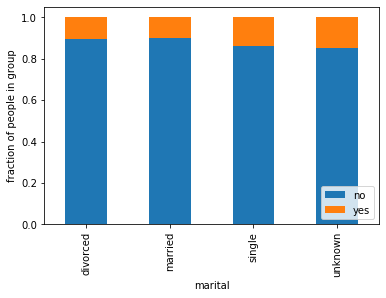

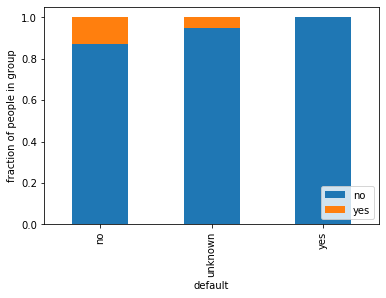

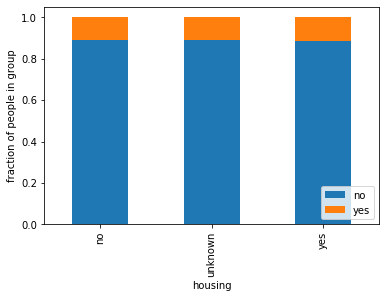

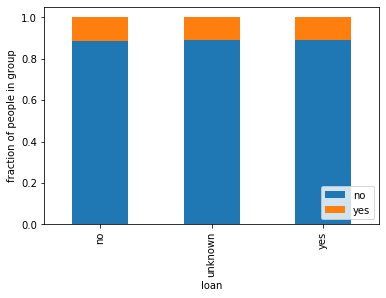

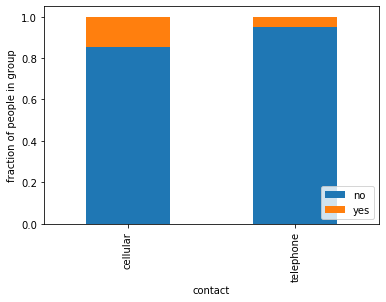

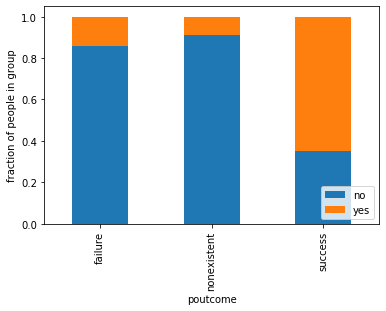

In [17]:
# Categorical features and categorical label (Stacked bar plot):

for i in range(len(onehot_ftrs)):

    count_matrix = df.groupby([onehot_ftrs[i], 'y']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True)
    plt.ylabel('fraction of people in group')
    plt.legend(loc=4)

plt.show()

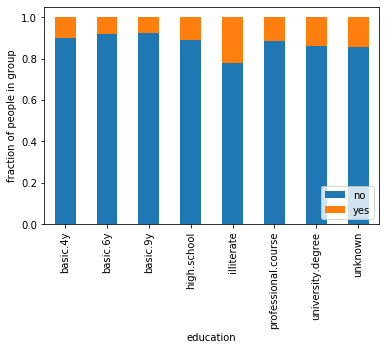

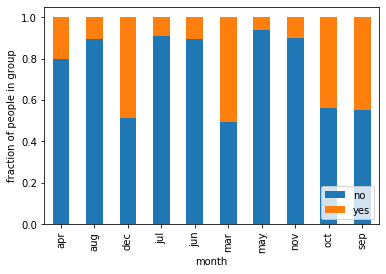

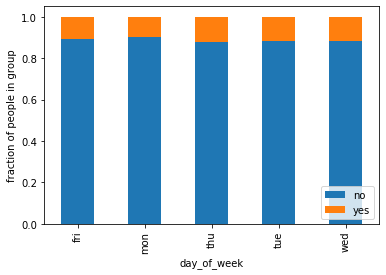

In [18]:
for i in range(len(ordinal_ftrs)):

    count_matrix = df.groupby([ordinal_ftrs[i], 'y']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True)
    plt.ylabel('fraction of people in group')
    plt.legend(loc=4)

plt.show()

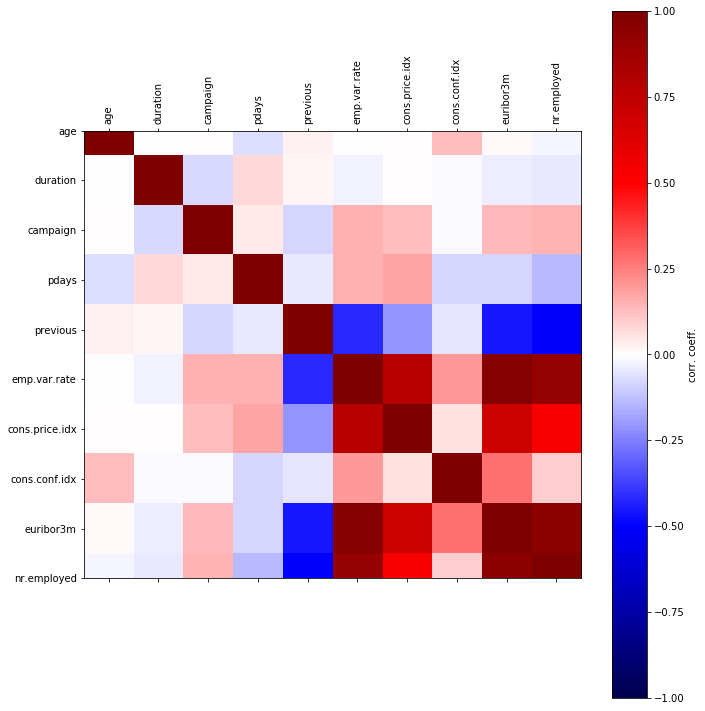

10


In [19]:
# Correlation matrix:

plt.figure(figsize=(10,10))
plt.matshow(df.corr(),vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(df.corr().shape[0]),list(df.corr().columns),rotation=90)
plt.yticks(np.arange(df.corr().shape[0]),list(df.corr().columns))
plt.tight_layout()
plt.show()

print(df.corr().shape[0])

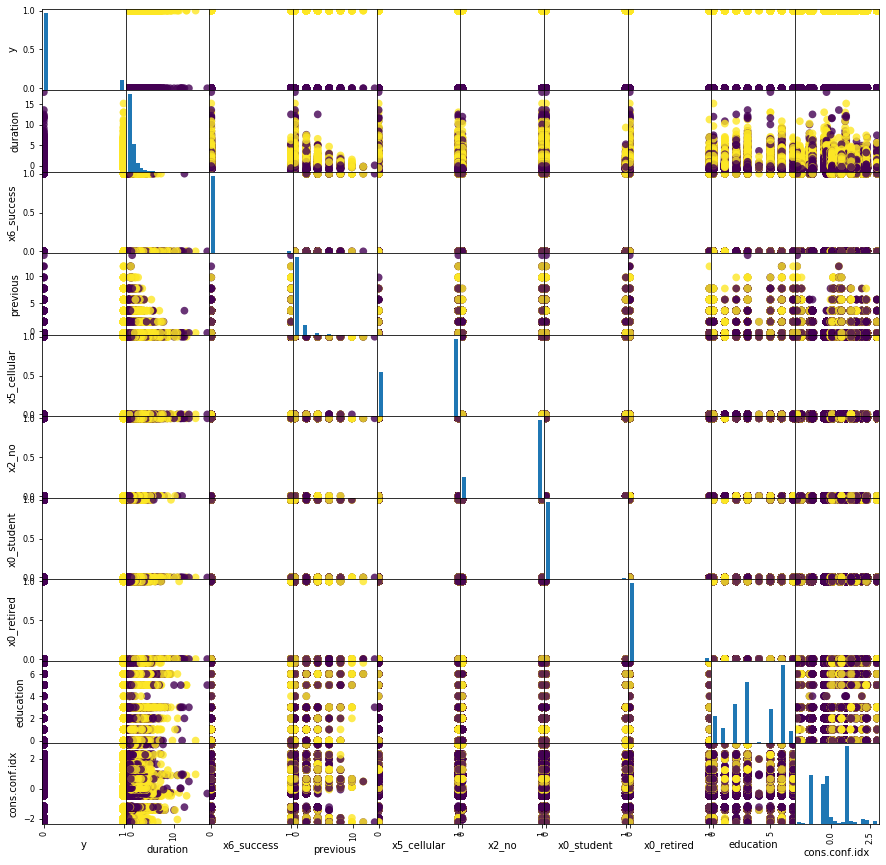

In [20]:
# Scatter matrix:

corrmat = result.corr()

all_cols = corrmat.sort_values('y',ascending=False)['y'].index 
cols = all_cols[:10] # positively correlated features
# cols = ['SalePrice']+[col for col in all_cols if '_nan' not in col][:-10:-1] # negatively correlated features

pd.plotting.scatter_matrix(result[cols],c = result['y'], figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()

count     41188
unique        2
top          no
freq      36548
Name: y, dtype: object


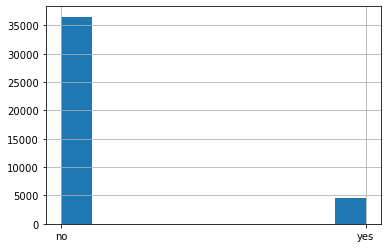

In [21]:
# Target Response: 

y = df['y']
print(y.describe())
y.hist()

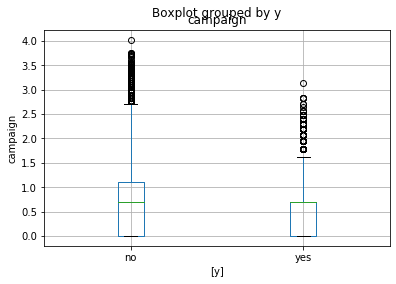

In [22]:
# Take log on 'campaign':

df['campaign'] = np.log(df['campaign'])
df[['campaign','y']].boxplot(by='y')
plt.ylabel('campaign')
plt.show()

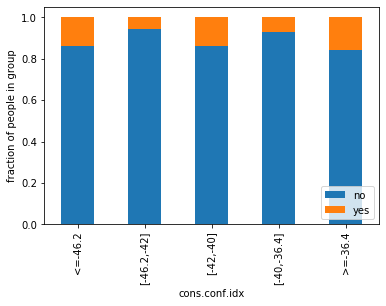

In [23]:
# Categorization 'cons.conf.idx':

df = pd.read_csv('Original Data.csv',sep=';')
df['cons.conf.idx'] = pd.cut(df['cons.conf.idx'],bins=[-60,-46.2,-42,-40,-36.4,-30],
                             labels=["<=-46.2", "[-46.2,-42]", "[-42,-40]", "[-40,-36.4]",">=-36.4"])
count_matrix = df.groupby(['cons.conf.idx', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)

plt.show()

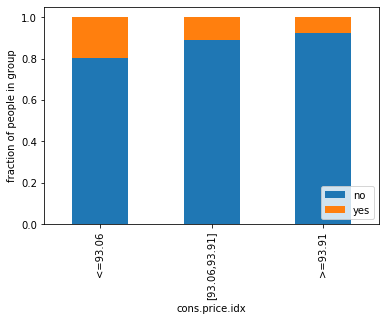

In [24]:
# Categorization 'cons.price.idx':

df = pd.read_csv('Original Data.csv',sep=';')
df['cons.price.idx'] = pd.cut(df['cons.price.idx'],bins=[90,93.06,93.91,95],
                             labels=["<=93.06", "[93.06,93.91]", ">=93.91"])
count_matrix = df.groupby(['cons.price.idx', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)

plt.show()

In [25]:
max(df['euribor3m'])

5.045

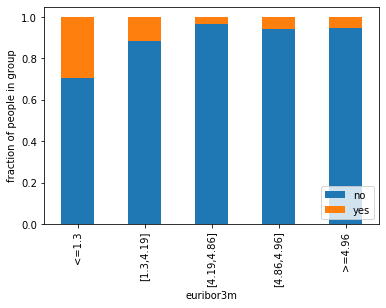

In [26]:
##### Categorization 'eur':

df = pd.read_csv('Original Data.csv',sep=';')
df['euribor3m'] = pd.cut(df['euribor3m'],bins=[0.6,1.3,4.19,4.86,4.96,5.1],
                             labels=["<=1.3", "[1.3,4.19]", "[4.19,4.86]", "[4.86,4.96]",">=4.96"])
count_matrix = df.groupby(['euribor3m', 'y']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.ylabel('fraction of people in group')
plt.legend(loc=4)

plt.show()

In [27]:
result

,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_missing,x0_retired,x0_self-employed,x0_services,x0_student,...,duration,campaign,previous,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010471,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.421501,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.124520,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.413787,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.187888,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.232513,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.460069,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.159232,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.469442,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.803333,-0.565922,-0.349494,NaN,0.648092,0.722722,0.886447,0.712460,0.331680,0
